In [1]:
# HAR classification 
# Author: Burak Himmetoglu
# 8/15/2017

import pandas as pd 
import numpy as np
import os

def read_data(data_path, split = "train"):
	""" Read data """

	# Fixed params
	n_class = 6
	n_steps = 128

	# Paths
	path_ = os.path.join(data_path, split)
	path_signals = os.path.join(path_, "Inertial_Signals")

	# Read labels and one-hot encode
	label_path = os.path.join(path_, "y_" + split + ".txt")
	labels = pd.read_csv(label_path, header = None)

	# Read time-series data
	channel_files = os.listdir(path_signals)
	channel_files.sort()
	n_channels = len(channel_files)
	posix = len(split) + 5

	# Initiate array
# 	list_of_channels = []
	X = np.zeros((len(labels), n_steps, n_channels))
	i_ch = 0
	for fil_ch in channel_files:
# 		channel_name = fil_ch[:-posix]
		dat_ = pd.read_csv(os.path.join(path_signals,fil_ch), delim_whitespace = True, header = None)
		X[:,:,i_ch] = dat_.as_matrix()

# 		# Record names
# 		list_of_channels.append(channel_name)

		# iterate
		i_ch += 1

	# Return 
	return X, labels[0].values#, list_of_channels

# test and train read
Xtrain, Ytrain = read_data(data_path="/home/arasdar/datasets/har/har-data/", split="train")
Xtest, Ytest = read_data(data_path="/home/arasdar/datasets/har/har-data/", split="test")

In [2]:
# # standardizing/normalizing the train and test data
# def standardize(train, test):
# """ Standardize data """
# # Standardize train and test
# X_train = (train - np.mean(train, axis=0)[None,:,:]) / np.std(train, axis=0)[None,:,:]
# X_test = (test - np.mean(test, axis=0)[None,:,:]) / np.std(test, axis=0)[None,:,:]
# return X_train, X_test

Xtrain = (Xtrain - Xtrain.mean(axis=0))/ Xtrain.std(axis=0)
Xtest = (Xtest - Xtest.mean(axis=0))/ Xtest.std(axis=0)
print(Xtrain.shape, Xtrain.dtype)
print(Xtest.shape, Xtest.dtype)

(7352, 128, 9) float64
(2947, 128, 9) float64


In [3]:
# Onehotencoding of the output labels
def onehot(labels, n_class):
	""" One-hot encoding """
	expansion = np.eye(n_class)
	y = expansion[:, labels-1].T
	assert y.shape[1] == n_class, "Wrong number of labels!"

	return y

print(Ytrain.max(axis=0), Ytest.max(axis=0))
# # assert Y.max(axis=0) == Ytrain.max(axis=0) == Ytest.max(axis=0), 'wrong labels'
Ytrain=onehot(labels=Ytrain, n_class=Ytrain.max(axis=0))
Ytest=onehot(labels=Ytest, n_class=Ytest.max(axis=0))
print(Ytrain.shape, Ytrain.dtype, Ytest.shape, Ytest.dtype)

6 6
(7352, 6) float64 (2947, 6) float64


In [4]:
from sklearn.model_selection import train_test_split

# Now separating train and validation set
# 30% of the training data/ entire training data is assigned to validation.
Xtrain, Xvalid, Ytrain, Yvalid = train_test_split(Xtrain, Ytrain, test_size=0.30)
print(Xtrain.shape, Xvalid.shape, Xtest.shape, Xtrain.dtype, Xvalid.dtype, Xtest.dtype)
print(Ytrain.shape, Yvalid.shape, Ytest.shape, Ytrain.dtype, Yvalid.dtype, Ytest.dtype)

(5146, 128, 9) (2206, 128, 9) (2947, 128, 9) float64 float64 float64
(5146, 6) (2206, 6) (2947, 6) float64 float64 float64


In [5]:
# In this one we should define and detect GPUs for tensorflow
# GPUs or CPU
import tensorflow as tf

# Check TensorFlow Version
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.7.0
Default GPU Device: /device:GPU:0


In [6]:
# now I can design the actual input and output tensors
N, W, Cin = Xvalid.shape[0], Xvalid.shape[1], Xvalid.shape[2]
X = tf.placeholder(dtype=tf.float32, name=None, shape=[N, W, Cin])
print(X.shape, X.dtype, Xtrain.shape, Xtrain.dtype, Xvalid.shape, Xvalid.dtype, Xtest.shape, Xtest.dtype)

(2206, 128, 9) <dtype: 'float32'> (5146, 128, 9) float64 (2206, 128, 9) float64 (2947, 128, 9) float64


In [7]:
# This is the output tensor for labels
N, Cout = Yvalid.shape[0], Yvalid.shape[1]
Y = tf.placeholder(dtype=tf.float32, name=None, shape=[N, Cout])
print(Y.shape, Y.dtype, Ytrain.shape, Ytrain.dtype, Yvalid.shape, Yvalid.dtype, Ytest.shape, Ytest.dtype)

(2206, 6) <dtype: 'float32'> (5146, 6) float64 (2206, 6) float64 (2947, 6) float64


In [8]:
print(X.shape, X.dtype)
Wwidth, Wchannels, Wnumber = X.shape[1].value//2, X.shape[2].value, X.shape[2].value*2
shape = [Wwidth, Wchannels, Wnumber]
initial_value = tf.random_normal(dtype=X.dtype, mean=0.0, name=None, shape=shape, stddev=1.0)
Wconv = tf.Variable(dtype=X.dtype, initial_value=initial_value, name=None, trainable=True)
print(Wconv.shape, Wconv.dtype)
Xconv = tf.nn.conv1d(data_format='NWC', filters=Wconv, name=None, padding='SAME', stride=2, use_cudnn_on_gpu=True, 
                     value=X)
Xconv = tf.maximum(name=None, x=(-0.1*Xconv), y=Xconv)
print(Xconv.shape, Xconv.dtype)

(2206, 128, 9) <dtype: 'float32'>
(64, 9, 18) <dtype: 'float32_ref'>
(2206, 64, 18) <dtype: 'float32'>


In [9]:
# This is the multiplication layer
# this part is flatening the input
shape = [Xconv.shape[0].value, Xconv.shape[1].value*Xconv.shape[2].value]
Xconv_reshaped = tf.reshape(name=None, shape=shape, tensor=Xconv)
print(Xconv_reshaped.shape, Xconv_reshaped.dtype)
# their first axis or dimension stay the same
shape = [Xconv_reshaped.shape[1].value, Y.shape[1].value]
initial_value = tf.random_normal(dtype=Xconv_reshaped.dtype, mean=0.0, name=None, shape=shape, stddev=1.0)
W = tf.Variable(dtype=Xconv_reshaped.dtype, initial_value=initial_value, name=None, trainable=True)
print(W.shape, W.dtype)
# The actual multiplication
# Y_ = Xconv_reshaped @ W
Y_ = tf.matmul(a=Xconv_reshaped, b=W, name=None)
print(Y_.shape, Y_.dtype)
print(Y.shape, Y.dtype)

(2206, 1152) <dtype: 'float32'>
(1152, 6) <dtype: 'float32_ref'>
(2206, 6) <dtype: 'float32'>
(2206, 6) <dtype: 'float32'>


In [10]:
# Now I need to calculate the loss
loss_tensor = tf.nn.softmax_cross_entropy_with_logits_v2(labels=Y, logits=Y_, name=None)
print(loss_tensor.shape, loss_tensor.dtype)
loss = tf.reduce_mean(axis=0, input_tensor=loss_tensor, name=None)
print(loss)

(2206,) <dtype: 'float32'>
Tensor("Mean:0", shape=(), dtype=float32)


In [11]:
# Backprop and SGD now using adam
opt = tf.train.AdamOptimizer().minimize(loss)
print(opt)

name: "Adam"
op: "NoOp"
input: "^Adam/update_Variable/ApplyAdam"
input: "^Adam/update_Variable_1/ApplyAdam"
input: "^Adam/Assign"
input: "^Adam/Assign_1"



In [12]:
def get_batches(X, Y, batch_size):
    """ Return a generator for batches """
    n_batches = len(X) // batch_size
    X, Y = X[:n_batches*batch_size], Y[:n_batches*batch_size]

    # Loop over batches and yield
    for b in range(0, len(X), batch_size):
        yield X[b:b+batch_size], Y[b:b+batch_size]

In [13]:
# We should save the after training and validation
saver = tf.train.Saver() 
train_loss_mean, valid_loss_mean = [], []

# now that we can calculate loss and optimize, we can start a session for calculating the error.
with tf.Session() as sess:
    sess.run(fetches=tf.global_variables_initializer())
    
    # for every epoch start feeding the arrays into the tensors in the model
    for epoch in range(0, 100, 1):
        train_loss, valid_loss = [], []
        
        # Training minibatches and feed them into the tensor
        for Xarr, Yarr in get_batches(X=Xtrain, Y=Ytrain, batch_size=Xvalid.shape[0]):
            # X_NxWxCin, Y_NxCout
            feed_dict = {X:Xarr, Y:Yarr}
            lossarr, _ = sess.run(feed_dict=feed_dict, fetches=[loss, opt])
            train_loss.append(lossarr)
            
        # Validation now which is one batch on every iteration
        for Xarr, Yarr in get_batches(X=Xvalid, Y=Yvalid, batch_size=Xvalid.shape[0]): 
            # X_NxWxCin, Y_NxCout
            feed_dict = {X:Xarr, Y:Yarr}
            lossarr = sess.run(feed_dict=feed_dict, fetches=[loss])
            valid_loss.append(lossarr)
        
        # printing out train and validation loss
        print('epoch:', epoch+1, 'train_loss:', np.mean(train_loss), 'valid_loss:', np.mean(valid_loss))
        
        # Every epoch, for drawing the plot and their learning curve
        train_loss_mean.append(np.mean(train_loss))
        valid_loss_mean.append(np.mean(valid_loss))
        
    # After all epochs and at the end of training and validation
    saver.save(sess,'checkpoints/cnn-imu-har.ckpt')

epoch: 1 train_loss: 525.66187 valid_loss: 505.19186
epoch: 2 train_loss: 493.74457 valid_loss: 474.83762
epoch: 3 train_loss: 463.147 valid_loss: 445.6669
epoch: 4 train_loss: 433.93146 valid_loss: 417.7286
epoch: 5 train_loss: 406.08807 valid_loss: 391.10663
epoch: 6 train_loss: 379.76703 valid_loss: 366.28937
epoch: 7 train_loss: 355.30298 valid_loss: 343.83286
epoch: 8 train_loss: 333.6137 valid_loss: 325.4274
epoch: 9 train_loss: 316.6133 valid_loss: 312.0421
epoch: 10 train_loss: 304.53568 valid_loss: 302.21707
epoch: 11 train_loss: 295.31067 valid_loss: 293.9592
epoch: 12 train_loss: 287.14966 valid_loss: 286.1668
epoch: 13 train_loss: 279.4102 valid_loss: 278.6969
epoch: 14 train_loss: 271.95233 valid_loss: 271.4867
epoch: 15 train_loss: 264.794 valid_loss: 264.62125
epoch: 16 train_loss: 257.91965 valid_loss: 258.07532
epoch: 17 train_loss: 251.32948 valid_loss: 251.88379
epoch: 18 train_loss: 245.0053 valid_loss: 245.98611
epoch: 19 train_loss: 238.997 valid_loss: 240.40096
e

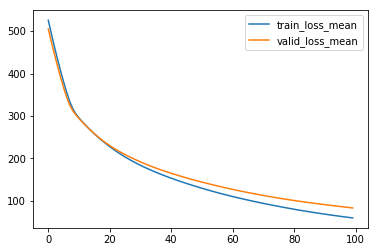

In [14]:
import matplotlib.pyplot as mplot
%matplotlib inline

mplot.plot(train_loss_mean, label='train_loss_mean')
mplot.plot(valid_loss_mean, label='valid_loss_mean')
mplot.legend()

In [15]:
with tf.Session() as sess:
    sess.run(fetches=tf.global_variables_initializer())
    
    # Loading the trained and validated model
    saver.restore(save_path=tf.train.latest_checkpoint(checkpoint_dir='checkpoints/'), sess=sess)
    
    # Saving the test loss for every batch/minibtch
    test_loss = []
    
    # applying the loaded model on test data
    for Xarr, Yarr in get_batches(X=Xtest, Y=Ytest, batch_size=Xvalid.shape[0]): 
        # X_NxWXCin, Y_NxCout
        feed_dict={X:Xarr, Y:Yarr}
        lossarr = sess.run(feed_dict=feed_dict, fetches=[loss])
        test_loss.append(lossarr)
        
    # Printing the test loss
    print('test_loss:', np.mean(test_loss))

INFO:tensorflow:Restoring parameters from checkpoints/cnn-imu-har.ckpt
test_loss: 111.51426
